# Inference of Sine Wave

In [1]:
import torch
from torch import tensor
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

## Make Dataset

In [2]:
timeline = np.arange(0, 60, 0.1)
y_np = (np.sin(timeline)).astype('f')
x_np = (y_np[:500] + (np.random.rand(len(timeline[:500])) * 0.2)).astype('f')  # Add noise

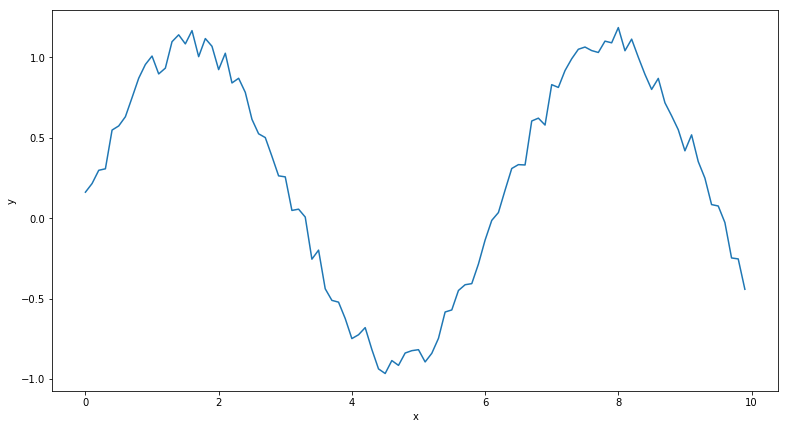

In [3]:
# input data
plt.figure(figsize=(13, 7))
plt.plot(timeline[0:100], x_np[0:100])

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
step_num = 100
pred_num = 1
X = []
y = []
for i in range(len(x_np) - step_num):
    X.append(x_np[i:i+step_num])
    y.append(y_np[i+step_num:i+step_num+pred_num])

### Example
index = 0  
X(input): timestep 0~99  
y(output): time 100

index = 1  
X(input): timestep 1~100  
y(output): time 101  

index = 2  
...  
index = 399  
X(input): timestep 400~499  
y(output): time 500

In [5]:
# Split DataSet and Make Batch
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(
    X, y, test_size=0.2, random_state=0)

## Training

In [6]:
class Model_lstm(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 1
        hidden_size = 10
        in_features = 1000
        out_features = 1
        layer1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1)
        self.layers = nn.ModuleList([layer1])
        fc1 = nn.Linear(in_features=in_features, out_features=out_features)
        self.functions = nn.ModuleList([fc1])
        
    def forward(self,x):
        x, c = self.layers[0](x) 
        x = F.relu(x)

        T, N, D = x.size()
        x = x.view(1, T*N*D)
        x = self.functions[0](x)
        
        return x

In [7]:
model_lstm = Model_lstm()

criterion = nn.MSELoss()

optimizer = optim.SGD(model_lstm.parameters(), lr=0.001, momentum=0.9)

In [8]:
epochs = 30

for epoch in range(epochs):

    total_loss = 0.0  # In 1-epoch

    for X, y in zip(X_train, y_train):
        inputs = torch.from_numpy(X).view(100, 1, 1)
        label = torch.from_numpy(y)
        inputs, label = Variable(inputs, requires_grad=True), Variable(label)
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs.view(1, 1), label.view(1, 1))
        loss.backward(retain_graph=True)
        optimizer.step()
        total_loss += loss.item()
    print('[{0:3},'.format(epoch + 1) + '{0:3d}]'.format(epochs) + 'loss: %.5f' % (total_loss))
    total_loss = 0.0

print('Finished Training')

[  1, 30]loss: 22.81293
[  2, 30]loss: 0.03317
[  3, 30]loss: 0.02259
[  4, 30]loss: 0.01978
[  5, 30]loss: 0.01894
[  6, 30]loss: 0.01864
[  7, 30]loss: 0.01848
[  8, 30]loss: 0.01835
[  9, 30]loss: 0.01824
[ 10, 30]loss: 0.01814
[ 11, 30]loss: 0.01804
[ 12, 30]loss: 0.01795
[ 13, 30]loss: 0.01786
[ 14, 30]loss: 0.01778
[ 15, 30]loss: 0.01770
[ 16, 30]loss: 0.01763
[ 17, 30]loss: 0.01756
[ 18, 30]loss: 0.01749
[ 19, 30]loss: 0.01743
[ 20, 30]loss: 0.01737
[ 21, 30]loss: 0.01731
[ 22, 30]loss: 0.01725
[ 23, 30]loss: 0.01720
[ 24, 30]loss: 0.01715
[ 25, 30]loss: 0.01710
[ 26, 30]loss: 0.01705
[ 27, 30]loss: 0.01701
[ 28, 30]loss: 0.01697
[ 29, 30]loss: 0.01692
[ 30, 30]loss: 0.01688
Finished Training


In [9]:
#PATH = "model_sin.pth"
#torch.save(model_lstm.state_dict(), PATH)  # Save model

## Inference

In [10]:
model_inf = model_lstm
#model_inf.load_state_dict(torch.load(PATH))  # Load model
model_inf.eval()

Model_lstm(
  (layers): ModuleList(
    (0): LSTM(1, 10)
  )
  (functions): ModuleList(
    (0): Linear(in_features=1000, out_features=1, bias=True)
  )
)

In [11]:
pred_size = len(y_np[500:600])
pred = x_np[400:500].tolist()
for i in range(pred_size):
    inputs_pred = torch.tensor(pred).view(100, 1, 1)
    output_pred = model_inf(inputs_pred)
    pred.pop(0)
    pred.append(output_pred.view(1).detach().tolist()[0])

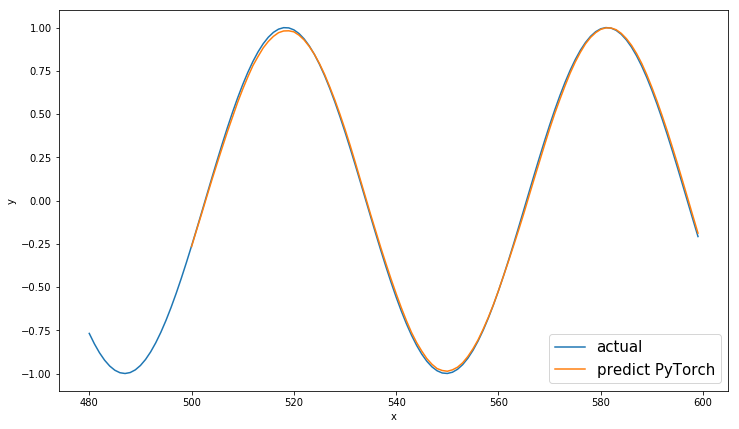

In [12]:
timeline_pred = np.arange(500, 600, 1)
timeline_act = np.arange(480, 600, 1)

plt.figure(figsize=(12, 7))
plt.plot(timeline_act, y_np[480:], label="actual")
plt.plot(timeline_pred, pred, label="predict PyTorch")
plt.legend(loc="lower right", fontsize="15")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Set parameters in C

In [13]:
from tool import get_model_data

In [14]:
model_data = get_model_data.GetDefinition(model=model_inf, input_x_row=100)

In [15]:
flatten_len = model_data.macro_len_str
params = model_data.variable_params_str
size = model_data.variable_size_str

In [16]:
path = '../src/main.c'

In [17]:
def change_param_c(filename, after_flatten_len, after_params, after_size):
    with open(filename) as test:
        strings = test.read()
    before_flatten_len = strings.split("// パラメーターの配列の長さの定義始まり\n")[-1].split("// パラメーターの配列の長さの定義終わり\n")[0]
    before_size = strings.split("      // パラメーターのサイズの定義始まり\n")[-1].split("      // パラメーターのサイズの定義終わり")[0]
    before_params = strings.split("      // パラメーターの定義始まり\n")[-1].split("      // パラメーターの定義終わり\n")[0]
    strings = strings.replace(before_flatten_len, after_flatten_len)
    strings = strings.replace(before_size, after_size)
    strings = strings.replace(before_params, after_params)
    with open(filename, mode='w') as test:
        test.write(strings)

In [18]:
change_param_c(path, flatten_len, params, size)

## Get stdout of C

In [19]:
import subprocess
import os
pred_stdout_c_lang = subprocess.Popen('../sample/lstm', stdout=subprocess.PIPE).communicate()[0]
pred_c_lang = [float(i.replace("b'", "").replace("'", "")) for i in str(pred_stdout_c_lang[:-1]).split("\\n")]

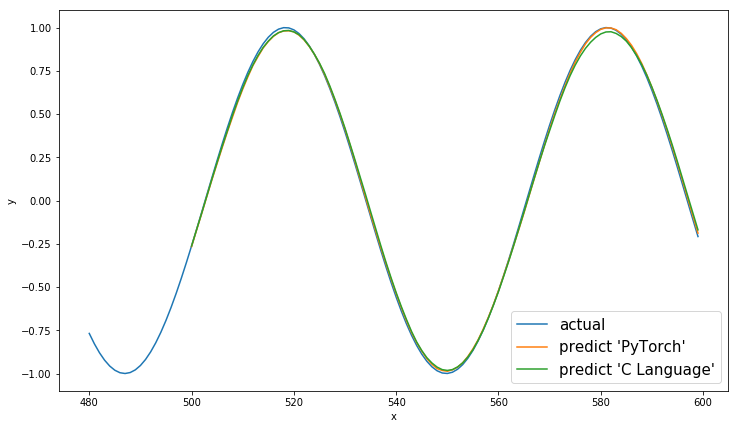

In [20]:
timeline_pred = np.arange(500, 600, 1)
timeline_act = np.arange(480, 600, 1)

plt.figure(figsize=(12, 7))
plt.plot(timeline_act, y_np[480:], label="actual")
plt.plot(timeline_pred, pred, label="predict 'PyTorch'")
plt.plot(timeline_pred, pred_c_lang, label="predict 'C Language'")
plt.legend(loc="lower right", fontsize="15")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

This result show that inference of C Language is much the same as inference of PyTorch

---

~~Sorry, we have not been able to set parameters of this model automatically yet.~~ (1/6/'19)  
**We can set parameters of this model automatically. (1/18)**